# Gesture Recognition


### Importing the Libraries

In [14]:
import numpy as np
import pandas as pd
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from imageio import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import random as rn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,GlobalAveragePooling2D, GlobalAveragePooling3D
from tensorflow.keras.layers import Conv3D, MaxPooling3D, ConvLSTM2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import LSTM

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In [3]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [4]:
train_doc = np.random.permutation(open('../datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('../datasets/Project_data/val.csv').readlines())
batch_size = 64

In [5]:
image_height = 120
image_width = 120
sequence_index = range(3, 28, 2)

---

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def fetch_batch_images(source_path, t, batch, batch_size_temp, crop_percentage, visualise, batch_size_const):
    """
    Helper Function For Loading the Images, performing 
    the preprocessing (Image Cropping and Resizing) 
    and returning the batch data and batch labels.
    
    :params:
    
    source_path : Data Directory
    sequence_index: Range of Images to consider for a given sequence
    t: Random Permutation of Folder List containing the sequences
    batch: Batch Index
    batch_size = batch size 
    crop_percentage: Percentage of Pixels to reduce across all axes
    [If 0.1: 10% integral values of total pixels will be reduced from all the 
    four sides]
    visualise: Flag for visualising the sequences
    """
    batch_data = np.zeros((batch_size_temp,len(sequence_index),image_height,image_width,3))
    batch_labels = np.zeros((batch_size_temp,5))
    
    for folder in range(batch_size_temp):
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size_const)].split(';')[0])
        for idx,item in enumerate(sequence_index):
            image = imread(source_path+'/'+ t[folder + (batch*batch_size_const)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            
            #cropping
            if crop_percentage is not None:
                start_y = int(crop_percentage * image.shape[0])
                end_y = image.shape[0] - start_y
                start_z = int(crop_percentage * image.shape[1])
                end_z = image.shape[1] - start_z
                image = image[start_y:end_y+1, start_z:end_z+1, :]
            
            #resizing
            resized_im = resize(image, output_shape=(image_height, image_width))
            if visualise:
                plt.subplot(2, len(sequence_index), idx+1)
                plt.imshow(resized_im.astype('uint8'))
            
            #normalizing
            batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255
            batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255
            batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255

        batch_labels[folder, int(t[folder + (batch*batch_size_const)].strip().split(';')[2])] = 1
#         batch_labels = np.reshape(batch_labels, (1,-1))
    return batch_data, batch_labels
    
def generator(source_path, folder_list, batch_size, crop_percentage = None, visualise = False):
    """
    Custom Generator function for loading images to batches
    Yields batch data and batch labels.
    
    :params:
    
    source_path : Data Directory
    folder_list : List of Folders within source path containing the images
    for the sequence
    t: Random Permutation of Folder List containing the sequences
    batch_size = batch size 
    crop_percentage: [Default = None] Percentage of Pixels to reduce across all axes
    [If 0.1: 10% integral values of total pixels will be reduced from all the 
    four sides]
    visualise: [Default = False] Flag for visualising the sequences
    
    """
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        for batch in range(num_batches):
            batch_data, batch_labels = fetch_batch_images(source_path, 
                                                         t, 
                                                         batch, batch_size, 
                                                         crop_percentage = crop_percentage, 
                                                         visualise = visualise,
                                                         batch_size_const = batch_size)
            yield batch_data, batch_labels
        
        #code for loading the remaining the rest of the sequences
        remaining_images = len(folder_list)%batch_size
        batch+=1
        if (remaining_images!=0):
            batch_data, batch_labels = fetch_batch_images(source_path, 
                                                         t, 
                                                         batch, remaining_images, 
                                                         crop_percentage = crop_percentage, 
                                                         visualise= visualise,
                                                         batch_size_const = batch_size)
            yield batch_data, batch_labels

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = '../datasets/Project_data/train'
val_path = '../datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


Source path =  ../datasets/Project_data/train ; batch size = 32


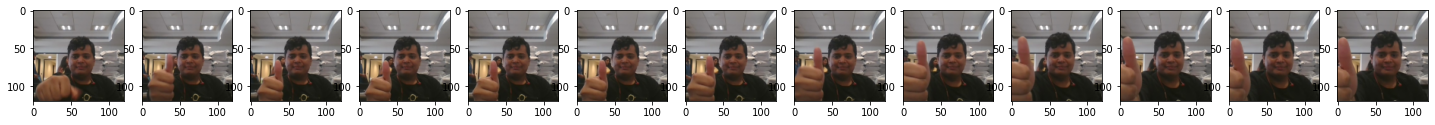

In [8]:
plt.figure(figsize = (25, 10))
visual = generator(
                   source_path = train_path, 
                   folder_list = train_doc,
                   batch_size = 32, 
                   crop_percentage = 0.1, 
                   visualise = True)
viz = next(visual)[0]

---

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
#Creating custom layer using keras.layers.Layer parent class

class conv3DBlock(keras.layers.Layer):
    """Custom Conv3d Block
    Layers included:
    > Conv3d
    > Batch Normalisation
    > Dropout
    > MaxPooling
    
    Args:
        out_channels: Number of convolutional filters/kernels
        kernel_size: Size of Each Kernel
        add_pooling: [Default = True] Flag for adding maxpooling layer
        add_batch_norm: [Default = False] Flag for adding batch normalisation
        add_dropout: [Default = None] Percentage of Dropout (if not None)

    """
    def __init__(self, out_channels, 
                 kernel_size, 
                 add_pooling = True,  
                 add_batch_norm = False, 
                 add_dropout= None,
                **kwargs):
        super(conv3DBlock, self).__init__(**kwargs)
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.add_pooling = add_pooling
        self.add_batch_norm = add_batch_norm
        self.add_dropout = add_dropout
        self.conv = Conv3D(filters = self.out_channels, kernel_size = self.kernel_size, padding = 'same')
        self.maxpooling = MaxPooling3D((2,2, 2))
        self.batch_norm = BatchNormalization()
        self.dropout = Dropout(rate = self.add_dropout)
    
    def call(self, input_tensor, training = False):
        x = self.conv(input_tensor)
        if self.add_batch_norm:
            x = self.batch_norm(x, training = training)
        if self.add_dropout:
            x = self.dropout(x)
        x = keras.layers.ReLU()(x)
        if self.add_pooling:
            x = self.maxpooling(x)
        return x
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'out_channels': self.out_channels,
            'kernel_size': self.kernel_size,
            'add_pooling': self.add_pooling,
            'add_batch_norm': self.add_batch_norm,
            'add_dropout': self.add_dropout,
        })
        return config

---

### Iteration 1

#### Defining the Sequential Model

In [11]:
input_shape = (len(sequence_index), image_height, image_width, 3)
model = Sequential([
    keras.layers.InputLayer(input_shape = input_shape),
    conv3DBlock(out_channels = 16, kernel_size = (3,3,3),add_pooling = False, add_dropout = None, add_batch_norm = True),
    conv3DBlock(out_channels = 32,kernel_size = (3,3,3), add_pooling = True, add_dropout = None ,add_batch_norm = True),
    conv3DBlock(out_channels =64,kernel_size = (3,3,3), add_pooling = True, add_dropout = 0.2, add_batch_norm = True),
    conv3DBlock(out_channels =64, kernel_size = (3,3,3), add_pooling = True, add_dropout = 0.2, add_batch_norm = True),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.2),
    Dense(64, activation = 'relu'),
    Dense(5, activation = 'softmax'),
    
])

2022-11-15 04:13:07.425203: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-15 04:13:07.425268: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


#### Compiling the Model

In [12]:
learning_rate = 0.01
optimiser = keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_block (conv3DBlock)  (None, 13, 120, 120, 16)  1376      
                                                                 
 conv3d_block_1 (conv3DBlock  (None, 6, 60, 60, 32)    13984     
 )                                                               
                                                                 
 conv3d_block_2 (conv3DBlock  (None, 3, 30, 30, 64)    55616     
 )                                                               
                                                                 
 conv3d_block_3 (conv3DBlock  (None, 1, 15, 15, 64)    110912    
 )                                                               
                                                                 
 flatten (Flatten)           (None, 14400)             0         
                                                        

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### Defining the Training Function

In [18]:
def train_model(model, init_folder_name, num_epochs):
    """Function for model training
    - Loads the generator data
    - Creates New directory for each run
    - Creates list of keras callbacks: checkpoint, LR Pleateau
    - Defines Number of Steps per  epoch
    - Trains Model
    
    :params:
    
    model: tensorflow.keras model
    init_folder_name: Name of Folder for each run to save the model .hdf5 files
    num_epochs: Number of Epochs
    """
    train_generator = generator(train_path, train_doc, batch_size, crop_percentage= 0.15)
    val_generator = generator(val_path, val_doc, batch_size, crop_percentage= 0.15)

    model_name = init_folder_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
      verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,
      min_lr = 0)
    callbacks_list = [checkpoint, LR]

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1
    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    history = model.fit_generator(train_generator,validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0,
              steps_per_epoch=steps_per_epoch,epochs=num_epochs, verbose=1,callbacks=callbacks_list, validation_data=val_generator)
    return history

### Training The Model

In [14]:
init_folder_name= "conv3D_Model1"
num_epochs = 40
batch_size = 64
history = train_model(model, init_folder_name, num_epochs)

Source path =  ../datasets/Project_data/train ; batch size = 64


/tmp/ipykernel_422/3459161347.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0,


Epoch 1/40


2022-11-15 04:13:29.857580: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - ETA: 0s - loss: 29.5886 - categorical_accuracy: 0.2036Source path =  ../datasets/Project_data/val ; batch size = 64

Epoch 00001: val_loss improved from inf to 1030.87195, saving model to conv3D_Model1_2022-11-1504_12_47.669855/model-00001-29.58862-0.20362-1030.87195-0.23000.hdf5
11/11 [==============================] - 67s 6s/step - loss: 29.5886 - categorical_accuracy: 0.2036 - val_loss: 1030.8719 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 3.0019 - categorical_accuracy: 0.2836
Epoch 00002: val_loss improved from 1030.87195 to 139.39186, saving model to conv3D_Model1_2022-11-1504_12_47.669855/model-00002-3.00193-0.28356-139.39186-0.26000.hdf5
11/11 [==============================] - 60s 6s/step - loss: 3.0019 - categorical_accuracy: 0.2836 - val_loss: 139.3919 - val_categorical_accuracy: 0.2600 - lr: 0.0100
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss

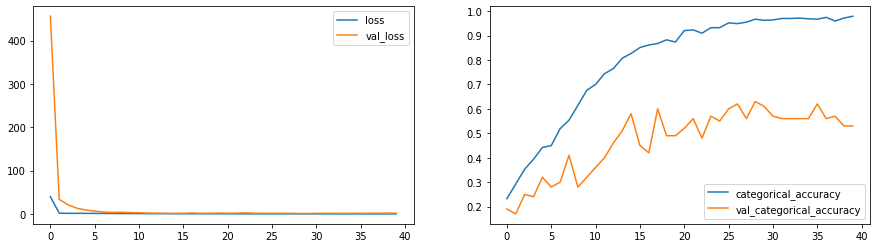

In [26]:
plot(history)

---

## Iteration 2

In [16]:
input_shape = (len(sequence_index), image_height, image_width, 3)
model = Sequential([
    keras.layers.InputLayer(input_shape = input_shape),
    conv3DBlock(out_channels = 16, kernel_size = (3,3,3),add_pooling = False, add_dropout = None, add_batch_norm = True),
    conv3DBlock(out_channels = 32,kernel_size = (3,3,3), add_pooling = True, add_dropout = None ,add_batch_norm = True),
    GlobalAveragePooling3D(),
    Dense(128, activation = 'relu'),
    Dropout(0.2),
    Dense(64, activation = 'relu'),
    Dense(5, activation = 'softmax'),
    
])

learning_rate = 0.01
optimiser = keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_block_8 (conv3DBlock  (None, 13, 120, 120, 16)  1376     
 )                                                               
                                                                 
 conv3d_block_9 (conv3DBlock  (None, 6, 60, 60, 32)    13984     
 )                                                               
                                                                 
 global_average_pooling3d_1   (None, 32)               0         
 (GlobalAveragePooling3D)                                        
                                                                 
 dense_12 (Dense)            (None, 128)               4224      
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                      

In [19]:
init_folder_name= "conv3D_Model2"
num_epochs = 40
batch_size = 64
history = train_model(model, init_folder_name, num_epochs)

Source path =  ../datasets/Project_data/train ; batch size = 64


/tmp/ipykernel_434/951725581.py:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0,


Epoch 1/40


2022-11-15 17:31:59.080112: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - ETA: 0s - loss: 1.5590 - categorical_accuracy: 0.2911Source path =  ../datasets/Project_data/val ; batch size = 64

Epoch 00001: val_loss improved from inf to 14.67199, saving model to conv3D_Model2_2022-11-1517_25_02.684134/model-00001-1.55900-0.29110-14.67199-0.23000.hdf5
11/11 [==============================] - 65s 6s/step - loss: 1.5590 - categorical_accuracy: 0.2911 - val_loss: 14.6720 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 1.4461 - categorical_accuracy: 0.3318
Epoch 00002: val_loss did not improve from 14.67199
11/11 [==============================] - 58s 6s/step - loss: 1.4461 - categorical_accuracy: 0.3318 - val_loss: 20.0548 - val_categorical_accuracy: 0.2500 - lr: 0.0100
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 1.3926 - categorical_accuracy: 0.3258
Epoch 00003: val_loss improved from 14.67199 to 11.13245, saving model to conv3D_Model

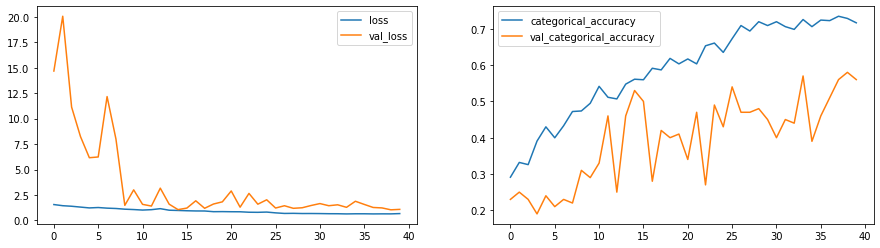

In [20]:
plot(history)

---

### Inference

- The Conv3D model was the hardest to optimise, it fails to learn the patterns on using fewer layers, but overfits on the data when using 4 layers (even after using 20% dropout)
- It achieves best accuracy of 66%, but due to more number of layers, the number of parameters is far more to be deployed onto a webcam, this will increase the inference time.

---

## CNN-LSTM Blocks

In [21]:
# Dfining custom layer class built on top of keras.layers.Layer parent class
class timeDistributedConv2D(keras.layers.Layer):
    """Custom Block for Time Distributed Conv2D
    Layers included:
    > Conv2D (Time Distributed)
    > Batch Normalisation (Time Distributed)
    > Dropout
    > MaxPooling (Time Distributed)
    
    Args:
        out_channels: Number of convolutional filters/kernels
        kernel_size: Size of Each Kernel
        add_pooling: [Default = True] Flag for adding maxpooling layer
        add_batch_norm: [Default = False] Flag for adding batch normalisation
        add_dropout: [Default = None] Percentage of Dropout (if not None)

    """
    def __init__(self, out_channels, kernel_size, add_pooling = True,  add_batch_norm = False, add_dropout= None, **kwargs):
        super(timeDistributedConv2D, self).__init__(**kwargs)
        self.out_channels = out_channels
        self.kernel_size= kernel_size
        self.add_pooling = add_pooling
        self.add_batch_norm = add_batch_norm
        self.add_dropout = add_dropout
        self.conv = TimeDistributed(Conv2D(filters = self.out_channels, kernel_size = self.kernel_size, padding = 'same'))
        self.maxpooling = TimeDistributed(MaxPooling2D((2,2)))
        self.batch_norm = TimeDistributed(BatchNormalization())
        self.dropout = TimeDistributed(Dropout(rate = self.add_dropout))
    
    def call(self, input_tensor, training = False):
        x = self.conv(input_tensor)
        if self.add_batch_norm:
            x = self.batch_norm(x, training = training)
        if self.add_dropout:
            x = self.dropout(x)
        x = TimeDistributed(keras.layers.ReLU())(x)
        if self.add_pooling:
            x = self.maxpooling(x)
        return x
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'out_channels': self.out_channels,
            'kernel_size': self.kernel_size,
            'add_pooling': self.add_pooling,
            'add_batch_norm': self.add_batch_norm,
            'add_dropout': self.add_dropout,
        })
        return config

### Defining The Model

---

### Iteration 1

In [24]:
input_shape = (len(sequence_index), image_height, image_width, 3)

model = Sequential([
    keras.layers.InputLayer(input_shape = input_shape),
    timeDistributedConv2D(out_channels = 16, kernel_size = (3,3), add_dropout = None, add_pooling = False, add_batch_norm = True),
    timeDistributedConv2D(out_channels = 32, kernel_size = (3,3), add_dropout = None, add_pooling = False, add_batch_norm = True),
    timeDistributedConv2D(out_channels = 32, kernel_size = (3,3), add_dropout = None, add_pooling = True, add_batch_norm = True),
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False),
    BatchNormalization(),
    TimeDistributed(Dense(64, activation='relu')),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

lr = 0.01
optimizer = keras.optimizers.Adam(lr= lr)
loss_fn = keras.losses.CategoricalCrossentropy(),
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_conv2d_2 (  (None, 13, 120, 120, 16)  512      
 timeDistributedConv2D)                                          
                                                                 
 time_distributed_conv2d_3 (  (None, 13, 120, 120, 32)  4768     
 timeDistributedConv2D)                                          
                                                                 
 time_distributed_conv2d_4 (  (None, 13, 60, 60, 32)   9376      
 timeDistributedConv2D)                                          
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 58, 58, 8)         11552     
                                                                 
 batch_normalization_17 (Bat  (None, 58, 58, 8)        32        
 chNormalization)                                     

---

#### Note:
- Training the model on batch size 64 causes OOM error, hence experimented with batch sizes, a batch size of 40 works best here

---

In [25]:
import warnings
warnings.simplefilter("ignore")
init_folder_name= "conv2d+LSTM_iter1"
num_epochs = 40
batch_size = 40
history = train_model(model, init_folder_name, num_epochs)

Source path =  ../datasets/Project_data/train ; batch size = 40
Epoch 1/40
17/17 [==============================] - ETA: 0s - loss: 1.5121 - categorical_accuracy: 0.3062Source path =  ../datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 1.65189, saving model to conv2d+LSTM_iter1_2022-11-1517_25_02.684134/model-00001-1.51206-0.30618-1.65189-0.23000.hdf5
17/17 [==============================] - 64s 4s/step - loss: 1.5121 - categorical_accuracy: 0.3062 - val_loss: 1.6519 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/40
17/17 [==============================] - ETA: 0s - loss: 1.2343 - categorical_accuracy: 0.4359
Epoch 00002: val_loss did not improve from 1.65189
17/17 [==============================] - 61s 4s/step - loss: 1.2343 - categorical_accuracy: 0.4359 - val_loss: 2.0184 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 3/40
17/17 [==============================] - ETA: 0s - loss: 1.1077 - categorical_accuracy: 0.5113
Epoch 00003:

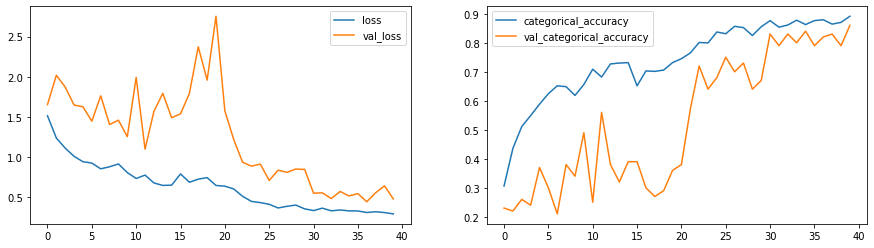

In [26]:
plot(history)

---

### Iteration 2

In [23]:
input_shape = (len(sequence_index), image_height, image_width, 3)

model = Sequential([
    keras.layers.InputLayer(input_shape = input_shape),
    timeDistributedConv2D(out_channels = 16, kernel_size = (3,3), add_dropout = None, add_pooling = False, add_batch_norm = True),
    timeDistributedConv2D(out_channels = 32, kernel_size = (3,3), add_dropout = None, add_pooling = False, add_batch_norm = True),
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False),
    BatchNormalization(),
    TimeDistributed(Dense(64, activation='relu')),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.05),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')

])

### Compiling The Model

In [27]:
lr = 0.01
optimizer = keras.optimizers.Adam(lr= lr)
loss_fn = keras.losses.CategoricalCrossentropy(),
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_conv2d_4 (  (None, 13, 120, 120, 16)  512      
 timeDistributedConv2D)                                          
                                                                 
 time_distributed_conv2d_5 (  (None, 13, 120, 120, 32)  4768     
 timeDistributedConv2D)                                          
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 118, 118, 8)       11552     
                                                                 
 batch_normalization_14 (Bat  (None, 118, 118, 8)      32        
 chNormalization)                                                
                                                                 
 time_distributed_26 (TimeDi  (None, 118, 118, 64)     576       
 stributed)                                           

---

### Training The Model

In [28]:
import warnings
warnings.simplefilter("ignore")
init_folder_name= "conv2d+LSTM"
num_epochs = 50
batch_size = 40
history = train_model(model, init_folder_name, num_epochs)

Source path =  ../datasets/Project_data/train ; batch size = 40
Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 1.4292 - categorical_accuracy: 0.3922Source path =  ../datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 1.81719, saving model to conv2d+LSTM_2022-11-1504_12_47.669855/model-00001-1.42917-0.39216-1.81719-0.18000.hdf5
17/17 [==============================] - 62s 4s/step - loss: 1.4292 - categorical_accuracy: 0.3922 - val_loss: 1.8172 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 1.2365 - categorical_accuracy: 0.4600
Epoch 00002: val_loss did not improve from 1.81719
17/17 [==============================] - 57s 4s/step - loss: 1.2365 - categorical_accuracy: 0.4600 - val_loss: 2.3414 - val_categorical_accuracy: 0.1700 - lr: 0.0100
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 1.0847 - categorical_accuracy: 0.4857
Epoch 00003: val_l

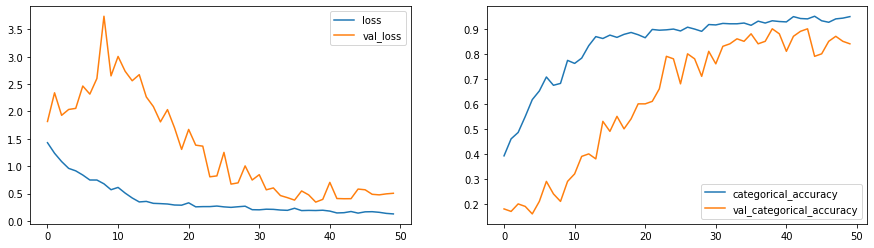

In [29]:
plot(history)

---
---

<h1>Remarks and Final Model</h1>

- After doing multiple experimentation, the above CNN-LSTM model is chosen as the best approach.
- The size of the model is kept very light with a total of 30,821 parameters out of which 30,581 are trainable parameters
- The CNN-LSTM model achieves the best performance on its 39th epoch, with best validation loss: 0.3433 and best validation accuracy: 90%
- This model is chosen as the final model

---
---

## Loading Model For Inference

#### 1. Load Best Model

<b>NOTE:</b> 
- Since the model uses custom layers, we need to run the cell defining the class for the layer before loading the model. In this case, the class is `timeDistributedConv2D`
- Also run the generator function for using it while loading the validation data

In [10]:
best_model = keras.models.load_model("best model/model-00039-0.18953-0.93213-0.34329-0.90000.hdf5",
                             custom_objects = {"timeDistributedConv2D": timeDistributedConv2D})

---

#### 2. Batch Inference

Note: 
- For inference, we load all images in a single batch, in this case, we need to supply `steps= number of sequences` while calling the evaluate generator


In [11]:
val_path = '../datasets/Project_data/val'
val_doc = np.random.permutation(open('../datasets/Project_data/val.csv').readlines())
batch_size = 1
num_val_sequences = len(val_doc)
val_generator = generator(val_path, val_doc, batch_size, crop_percentage= 0.15)

In [12]:
best_model.evaluate_generator(val_generator, steps = num_val_sequences, verbose = True)

<ipython-input-12-1a13c354efd8>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  best_model.evaluate_generator(val_generator, steps = num_val_sequences, verbose = True)


Source path =  ../datasets/Project_data/val ; batch size = 1
100/100 [==============================] - 44s 433ms/step - loss: 0.4080 - categorical_accuracy: 0.8700


[0.40800532698631287, 0.8700000047683716]

<b>Note: </b> When checked in local, the performance drops to 87%, but that may be due to slightly different sequences present in Validation Data in Jarvis and the one provided on Upgard portal

---

#### 3. Single Inference

In [13]:
def predict_label(data, best_model):
    """Function for model prediction for single sequence
    
    :params:
    
    data: sequence data (containing batch data and labels)
    best_model : Keras model loaded from .hdf5 file/trained model
    
    :returns:
    
    df_val: pandas DataFrame containing actual label and prediction
    """

    df_val = pd.DataFrame()
    df_val['Labels'] = [0,1,2,3,4]
    df_val['Action'] = ['Left Swipe', 'Right Swipe', 'Stop', 'Thumbs Down', 'Thumbs Up']
    
    sequence = data[0]
    labels = data[1]
    predictions = best_model.predict(sequence)
    df_val['Current Label'] = labels[0]
    df_val['Current Prediction'] = predictions[0]
    df_val['Current Prediction'] = df_val['Current Prediction'].apply(lambda x: np.round(x, 5))
    return df_val

Source path =  ../datasets/Project_data/val ; batch size = 1


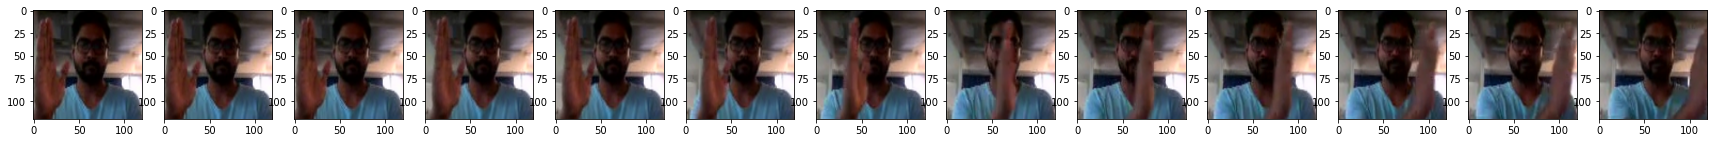

In [14]:
plt.figure(figsize = (30, 10))
data_gen = generator(
                   source_path = val_path, 
                   folder_list = val_doc,
                   batch_size = batch_size, 
                   crop_percentage = 0.15, 
                   visualise = True)
data = next(data_gen)

In [15]:
df_results = predict_label(data, best_model)
df_results

1/1 [==============================] - 1s 523ms/step


,Labels,Action,Current Label,Current Prediction
0,0,Left Swipe,1.0,0.99057
1,1,Right Swipe,0.0,0.00708
2,2,Stop,0.0,0.00216
3,3,Thumbs Down,0.0,0.00019
4,4,Thumbs Up,0.0,0.00000


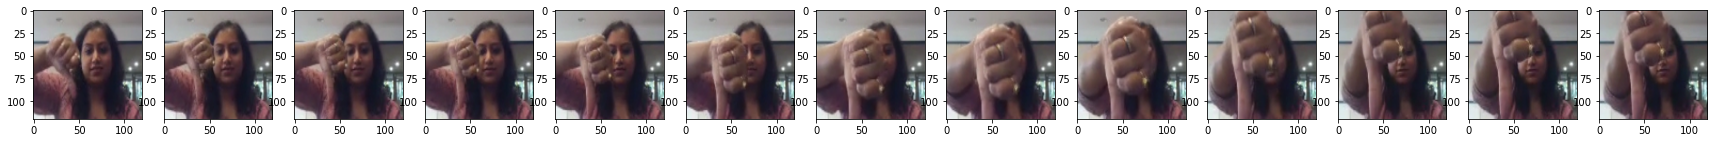

In [16]:
plt.figure(figsize = (30, 10))
data2 = next(data_gen)

In [17]:
df_results = predict_label(data2, best_model)
df_results

1/1 [==============================] - 0s 165ms/step


,Labels,Action,Current Label,Current Prediction
0,0,Left Swipe,0.0,0.00001
1,1,Right Swipe,0.0,0.00000
2,2,Stop,0.0,0.00035
3,3,Thumbs Down,1.0,0.99920
4,4,Thumbs Up,0.0,0.00044


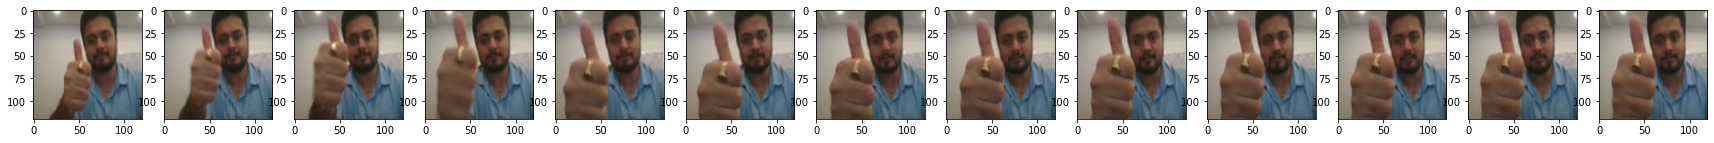

In [18]:
plt.figure(figsize = (30, 10))
data3 = next(data_gen)

In [19]:
df_results = predict_label(data3, best_model)
df_results

1/1 [==============================] - 0s 159ms/step


,Labels,Action,Current Label,Current Prediction
0,0,Left Swipe,0.0,0.00000
1,1,Right Swipe,0.0,0.00000
2,2,Stop,0.0,0.00005
3,3,Thumbs Down,0.0,0.03512
4,4,Thumbs Up,1.0,0.96482
